In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import jax
import jax.numpy as jnp

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils
    from probml_utils import savefig, latexify

from probml_utils.pyprobml_utils import plot_ellipse

try:
    from bijax.advi import ADVI
except ModuleNotFoundError:
    %pip install git+https://github.com/patel-zeel/bijax
    from bijax.advi import ADVI

from bijax.utils import train_fn

try:
    import optax
except:
    %pip install optax
    import optax

from jax.config import config

config.update("jax_enable_x64", True)

In [9]:
latexify(width_scale_factor=1, fig_height=1.5)

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Generate data

In [2]:
prior_mean = jnp.array([1.0, 2.0])
prior_covar = jnp.array([[2.0, 0.5], [0.5, 1.0]])
prior = {"x": tfd.MultivariateNormalFullCovariance(loc=prior_mean, covariance_matrix=prior_covar)}

In [3]:
likelihood_covar = jnp.array([[0.5, 0.3], [0.3, 0.6]])


def likelihood_fn(params, inputs=None):
    return tfd.MultivariateNormalFullCovariance(loc=params["x"], covariance_matrix=likelihood_covar)

In [4]:
model = ADVI(prior=prior, likelihood_fn=likelihood_fn, vi_type="mean_field")

In [5]:
N_points = 10
key = jax.random.PRNGKey(123)
prior_generative_distribution = model.get_generative_distribution(latent_distribution=prior)
outputs = prior_generative_distribution.sample(key, inputs=None, sample_shape=(N_points,))
outputs.shape

(10, 2)

## Analytic solution

In [6]:
likelihood_covar_inv = jnp.linalg.inv(likelihood_covar)
prior_covar_inv = jnp.linalg.inv(prior_covar)
true_posterior_covar = jnp.linalg.inv(prior_covar_inv + N_points * likelihood_covar_inv)
true_posterior_mean = true_posterior_covar @ (
    likelihood_covar_inv @ (N_points * outputs.mean(axis=0)) + prior_covar_inv @ prior_mean
)
true_posterior_mean, true_posterior_covar

(DeviceArray([0.39483411, 1.67606737], dtype=float64),
 DeviceArray([[0.04846467, 0.02830189],
              [0.02830189, 0.05660377]], dtype=float64))

## Train ADVI and plot

/home/patel_zeel/miniconda3/envs/ajax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


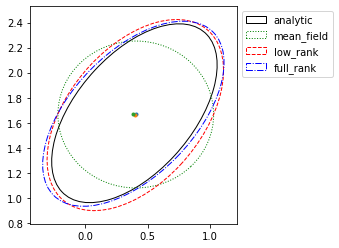

In [7]:
fig, ax = plt.subplots()

plot_ellipse(true_posterior_covar, true_posterior_mean, ax, plot_center=False, label="analytic")
vi_types = ["mean_field", "low_rank", "full_rank"]
colors = ["green", "red", "blue"]
linestyles = ["dotted", "dashed", "-."]

results = []
for vi_type, color, linestyle in zip(vi_types, colors, linestyles):
    if vi_type == "low_rank":
        model = ADVI(prior=prior, likelihood_fn=likelihood_fn, vi_type=vi_type, rank=1)
    else:
        model = ADVI(prior=prior, likelihood_fn=likelihood_fn, vi_type=vi_type)

    key = jax.random.PRNGKey(10)
    params = model.init(key)
    optimizer = optax.adam(learning_rate=0.01)

    key, subkey = jax.random.split(key)
    n_mc_samples = 1
    loss_fn = jax.tree_util.Partial(
        model.loss_fn,
        outputs=outputs,
        inputs=None,
        full_data_size=N_points,
        seed=key,
        n_samples=n_mc_samples,
    )

    n_epochs = 1000
    result = train_fn(loss_fn, params, optimizer, n_epochs=n_epochs, seed=subkey)
    results.append(result)

    posterior = model.get_params_posterior(result["params"]).posterior

    mean = posterior.mean()
    covariance = posterior.covariance()
    plot_ellipse(covariance, mean, ax, edgecolor=color, plot_center=True, label=vi_type, linestyle=linestyle)

ax.set_aspect("equal")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend(bbox_to_anchor=(1, 1))
savefig("gaussian_2d_advi");

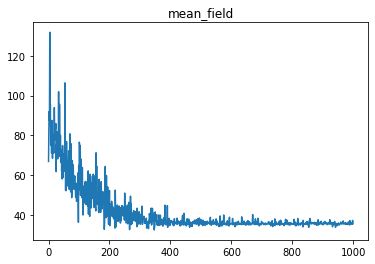

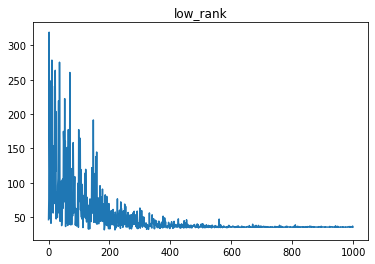

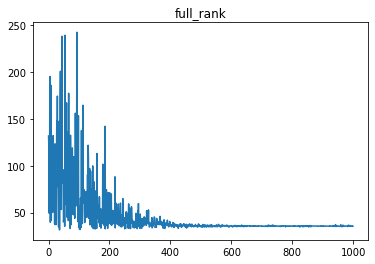

In [8]:
for vi_type, result in zip(vi_types, results):
    plt.figure()
    plt.plot(result["losses"])
    plt.title(vi_type)